In [1]:
import numpy as np
class MIGCore:
    """
    Core functionality for covariance matrix generation and basic operations
    Implements Eq. (3) and (5) from the paper
    """
    
    def __init__(self):
        pass
    
    def generate_covariance_matrix(self, z: np.ndarray, smooth: bool = False) -> np.ndarray:
        """
        Generate covariance matrix from signal vector z as in Eq. (3) and (5)
        """
        n = len(z)
        

        r = self.compute_correlation_coefficients(z, smooth)
        
        R = self.build_toeplitz_matrix(r)
        return R
    
    def compute_correlation_coefficients(self, z: np.ndarray,smoothed:bool=False) -> np.ndarray:
        """Compute correlation coefficients r = [r_0, r_1, ..., r_{n-1}]"""
        n = len(z)
        r = np.zeros(n, dtype=complex)
        
        for i in range(n):
            if i == 0:
                r[i] = np.mean(z * np.conj(z))
            else:
                sum_val = 0
                for j in range(0, n - i):
                    sum_val += z[j] * np.conj(z[j + i])
                r[i] = sum_val / n
                if smoothed:
                    r[i]=r[i]*np.sinc(i*n**(-0.2)/2)
        return r

    def get_symbol_from_corr(self,r:np.ndarray):
        n = len(r)
    
        # Method 1: Direct formula (clear)
        f = np.zeros(n, dtype=float)
        
        # j = 0,...,n-1
        j = np.arange(n)
        
        # Add r_0 term
        f += r[0].real  # r_0 is real
        
        # Add terms for k = 1,...,n-1
        for k in range(1, n):
            phase = 2 * np.pi * j * k / n
            # r_k * exp(-i*phase) + conj(r_k) * exp(i*phase)
            f += 2 * (r[k].real * np.cos(phase) + r[k].imag * np.sin(phase))
        
        return f
    
    def build_toeplitz_matrix(self, r: np.ndarray) -> np.ndarray:
        """
        Build Toeplitz HPD matrix from correlation coefficients as in Eq. (3)
        """
        n = len(r)
        R = np.zeros((n, n), dtype=complex)
        
        for i in range(n):
            for j in range(n):
                if i == j:
                    R[i, j] = r[0]
                elif i < j:
                    R[i, j] = np.conj(r[j - i])
                else:
                    R[i, j] = r[i - j]
        
        if not self.is_hpd(R):
            R += 1e-10 * np.eye(n)
            
        return R
    
    def is_hpd(self, R: np.ndarray) -> bool:
        """Check if matrix is Hermitian Positive Definite"""
        if not np.allclose(R, R.conj().T):
            return False
        try:
            np.linalg.cholesky(R)
            return True
        except np.linalg.LinAlgError:
            return False
    
    def generate_test_signal(self, n: int, signal_type: str = 'random') -> np.ndarray:
        """Generate test signal for validation"""
        if signal_type == 'random':
            return np.random.randn(n) + 1j * np.random.randn(n)
        elif signal_type == 'sinusoid':
            t = np.linspace(0, 1, n)
            return np.exp(1j * 2 * np.pi * 5 * t) + 0.1 * (np.random.randn(n) + 1j * np.random.randn(n))
        else:
            return np.random.randn(n) + 1j * np.random.randn(n)

In [2]:
core = MIGCore()
    
# Test 1: Basic signal to covariance matrix
z = np.array([1+1j, 2+0j, 1-1j, 0+1j])
R_s = core.generate_covariance_matrix(z,True)
R = core.generate_covariance_matrix(z,False)
print(f"Input signal: {z}")

print(f"Covariance matrix shape: {R.shape}")
print(f"Is HPD: {core.is_hpd(R)}")
print(f"Matrix is Hermitian: {np.allclose(R, R.conj().T)}")
print(f"Covariance matrix:\n{R}")
print(f"Smoothed Covariance matrix:\n{R_s}")

Input signal: [1.+1.j 2.+0.j 1.-1.j 0.+1.j]
Covariance matrix shape: (4, 4)
Is HPD: True
Matrix is Hermitian: True
Covariance matrix:
[[2.25+0.j   0.75-0.75j 0.  -0.j   0.25+0.25j]
 [0.75+0.75j 2.25+0.j   0.75-0.75j 0.  -0.j  ]
 [0.  +0.j   0.75+0.75j 2.25+0.j   0.75-0.75j]
 [0.25-0.25j 0.  +0.j   0.75+0.75j 2.25+0.j  ]]
Smoothed Covariance matrix:
[[ 2.25      +0.j          0.58499294-0.58499294j  0.        -0.j
  -0.02916466-0.02916466j]
 [ 0.58499294+0.58499294j  2.25      +0.j          0.58499294-0.58499294j
   0.        -0.j        ]
 [ 0.        +0.j          0.58499294+0.58499294j  2.25      +0.j
   0.58499294-0.58499294j]
 [-0.02916466+0.02916466j  0.        +0.j          0.58499294+0.58499294j
   2.25      +0.j        ]]


In [3]:
def generate_real_Toeplitz_covariance(n: int) -> np.ndarray:
    # generate a random Toeplitz covariance matrix r0...rn-1
    r = np.zeros(n, dtype=complex)
    r[0]=1
    for i in range(1, n):
        r[i] = np.random.uniform(0, 1/i)
        theta=np.random.uniform(0,2*np.pi)
        r[i] *= np.exp(1j * theta)
    return r



In [4]:
from numpy import ndarray
from scipy.linalg import sqrtm
def generate_samples(r:ndarray,num_samples:int):
    # T_r=core.build_toeplitz_matrix(r)
    T_t=sqrtm(r)
    n = len(r)
    z_std = (np.random.randn(n, num_samples) + 1j*np.random.randn(n, num_samples)) / np.sqrt(2)
    Z = T_t @ z_std
    return Z

In [5]:
r=generate_real_Toeplitz_covariance(1024)
R=core.build_toeplitz_matrix(r)
Z=generate_samples(R,100)
print(Z.shape)

(1024, 100)


In [49]:
corr=core.generate_covariance_matrix(Z[:,0])
corr

array([[ 1.34134841e+00+3.24670799e-19j, -1.98777236e-01-2.74053942e-01j,
        -1.07719205e-01+2.06339415e-03j, ...,
        -1.44942755e-03-1.11235310e-04j,  2.92247471e-04+1.24001883e-03j,
        -2.53417572e-04-1.49176006e-04j],
       [-1.98777236e-01+2.74053942e-01j,  1.34134841e+00+3.24670799e-19j,
        -1.98777236e-01-2.74053942e-01j, ...,
         1.06426187e-03-1.68055096e-04j, -1.44942755e-03-1.11235310e-04j,
         2.92247471e-04+1.24001883e-03j],
       [-1.07719205e-01-2.06339415e-03j, -1.98777236e-01+2.74053942e-01j,
         1.34134841e+00+3.24670799e-19j, ...,
         2.10442442e-03+4.37408842e-05j,  1.06426187e-03-1.68055096e-04j,
        -1.44942755e-03-1.11235310e-04j],
       ...,
       [-1.44942755e-03+1.11235310e-04j,  1.06426187e-03+1.68055096e-04j,
         2.10442442e-03-4.37408842e-05j, ...,
         1.34134841e+00+3.24670799e-19j, -1.98777236e-01-2.74053942e-01j,
        -1.07719205e-01+2.06339415e-03j],
       [ 2.92247471e-04-1.24001883e-03j, -1.

In [5]:
import scipy.linalg as la
def riemannian_distance(R1: np.ndarray, R2: np.ndarray) -> float:
        """
        Riemannian Distance (RD) as in Eq. (10): ‖log(R1⁻¹ R2)‖_F
        """
        try:
            R1_inv = np.linalg.inv(R1)
            M = R1_inv @ R2
            log_M = la.logm(M)
            eival,eivect=np.linalg.eigh(log_M)
            #print(eival)
            return np.linalg.norm(log_M, 'fro')
        except (np.linalg.LinAlgError, la.LinAlgError):
            print("ERROR!")
            return np.linalg.norm(R1 - R2, 'fro')

In [6]:
def compute_errors(Z:ndarray,num_samples:int,r:ndarray):
    d=np.zeros(num_samples)
    d_s=np.zeros(num_samples)
    for i in range(num_samples):
        z=Z[:,i]
        corr=core.generate_covariance_matrix(z)
        corr_s=core.generate_covariance_matrix(z,True)
        d[i]=riemannian_distance(corr, r)
        d_s[i]=riemannian_distance(corr_s, r)
    return d, d_s

In [11]:
def line(n:int,num_samples:int):
    r=generate_real_Toeplitz_covariance(n)
    R=core.build_toeplitz_matrix(r)
    Z=generate_samples(R,num_samples)
    d,d_s=compute_errors(Z,num_samples,R)
    return d, d_s

In [72]:
d,d_s=line(1024,100)

In [73]:
d

array([71.62521079, 70.44544747, 72.21075573, 71.54437087, 72.87346224,
       71.75181184, 70.94650086, 72.90700205, 71.68162362, 72.13896729,
       69.96226906, 73.26725269, 71.86331772, 71.57920671, 71.13526265,
       71.96044179, 72.48146427, 72.38554005, 71.3024876 , 72.04194459,
       72.52454517, 72.11169106, 71.20709995, 72.25091813, 70.93662352,
       72.36419177, 72.34376344, 71.53327758, 72.06549699, 71.95083774,
       73.27745453, 72.01491274, 71.31433913, 72.67118634, 71.66398805,
       72.0042577 , 71.62005122, 71.93888794, 72.82742838, 73.34118602,
       71.67337676, 71.81832273, 72.46921444, 72.97728701, 72.74594054,
       72.0488022 , 72.26585015, 71.15384361, 71.44202641, 71.96041397,
       71.45420817, 70.45820198, 73.71042643, 71.74471896, 72.2865291 ,
       73.7530494 , 71.46169818, 71.75944479, 72.2036414 , 72.1213944 ,
       70.95424586, 73.19851895, 71.72092859, 72.41434657, 71.17098567,
       72.14949013, 74.12547337, 72.3632211 , 72.14490172, 71.03

In [74]:
d_s

array([59.3555291 , 59.15880733, 59.56636432, 59.0291884 , 59.41714169,
       59.65648267, 59.17093113, 59.46151861, 59.67520627, 59.67347282,
       59.37387476, 59.39795381, 59.10744768, 59.20903236, 59.38796961,
       59.55523366, 58.73146925, 59.60617464, 59.24020621, 59.82529708,
       59.89901851, 59.64740051, 59.22911571, 59.58409181, 59.45288274,
       59.25405935, 59.76904106, 59.49432556, 59.39797396, 60.05117013,
       59.3990291 , 59.3298066 , 59.34090805, 59.2594006 , 59.33648323,
       58.89882726, 59.95820802, 59.0267523 , 59.55455046, 60.15502798,
       59.33859814, 60.09819758, 59.57252323, 60.19668251, 59.65667981,
       59.31958269, 59.77922038, 59.106562  , 58.53774754, 59.95528178,
       59.54403365, 59.25543727, 60.05963733, 59.69039781, 58.91803738,
       59.69151536, 59.72013163, 58.96311212, 59.87045949, 59.73771101,
       59.89175865, 59.90378848, 58.86897738, 59.77997875, 58.7364238 ,
       60.02005061, 59.98098495, 59.2943084 , 59.56368184, 59.33

In [7]:
def circular_moving_average(signal, hw):
        """循环移动平均，hw为半宽"""
        n_sig = len(signal)
        smoothed = np.zeros_like(signal)
        
        for i in range(n_sig):
            # 循环索引：i-hw 到 i+hw
            indices = np.arange(i - hw, i + hw + 1) % n_sig
            smoothed[i] = np.mean(signal[indices])
        
        return smoothed
def transform_vector(x,smooth=False):
    n = len(x)
    X = np.fft.fft(np.conjugate(x))
    Px = np.abs(X)**2 / n
    half_width = int(np.round(n**0.8 / (4 * np.pi)))
    # print(half_width)
    if smooth:
        Px = circular_moving_average(Px, half_width)
    eps = 1e-10
    Lx = np.log(np.maximum(Px, eps))
    return Lx
def riemannian_distance_optimized(x, y,smooth=False):
    Lx=transform_vector(x,smooth)
    Ly=transform_vector(y,smooth)
    D = np.sqrt(np.sum((Lx - Ly)**2))
    return D

In [8]:
def standard_distance(n:int,smooth=False):
    core=MIGCore()
    r1=generate_real_Toeplitz_covariance(n)
    r2=generate_real_Toeplitz_covariance(n)
    R1=core.build_toeplitz_matrix(r1)
    R2=core.build_toeplitz_matrix(r2)
    x=generate_samples(R1,1)
    y=generate_samples(R2,1)
    x=x.ravel()
    y=y.ravel()
    print("Start calculation")
    
    corr_x=core.generate_covariance_matrix(x,smooth)
    corr_y=core.generate_covariance_matrix(y,smooth)
    # print("symbol:",s1,s2)
    d=riemannian_distance(corr_x, corr_y)
    print(f"Riemannian distance: {d}")
    # lx=riemannian_distance_smooth_fixed_fast(x)
    # ly=riemannian_distance_smooth_fixed_fast(y)
    d_approx = riemannian_distance_optimized(x, y,smooth)
    print(f"Approximate distance: {d_approx}")
    #print(f"Corrected approximation:{d_approx/(np.sqrt(np.pi/2))}")
    return d, d_approx

In [65]:
d,da=standard_distance(128)

Start calculation
Riemannian distance: 18.17704656099198
Approximate distance: 26.670004279045546


In [61]:
import matplotlib.pyplot as plt


In [9]:
import matplotlib.pyplot as plt
def experiment_pipeline(n:int):
    d=[]
    d_a=[]
    axis=[]
    for i in range(100):
        d1,da1= standard_distance(n,True)
        d.append(d1)
        d_a.append(da1)
        axis.append(i)
    plt.scatter(np.log(d),np.log(d_a),color='r')
    intercept=np.mean(np.log(d_a)-np.log(d))
    x=np.linspace(0,3,100)
    y=x+intercept
    plt.plot(x,y)
    plt.show()
    print(intercept)
    return d,d_a
d,da=experiment_pipeline(128)
    

Start calculation
Riemannian distance: 6.6197692514274475
Approximate distance: 10.580909636807762
Start calculation
Riemannian distance: 10.635858516575912
Approximate distance: 13.19222913343142
Start calculation
Riemannian distance: 7.3059116508536786
Approximate distance: 11.405155784435227
Start calculation
Riemannian distance: 16.112089180470434
Approximate distance: 18.829089400529696
Start calculation
Riemannian distance: 10.297057763109752
Approximate distance: 13.694888972763884
Start calculation


KeyboardInterrupt: 

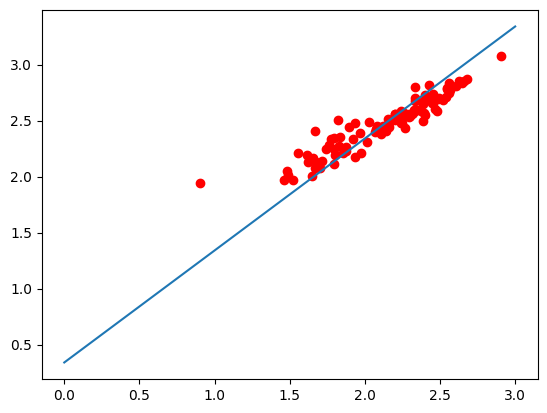

0.3396155922874488


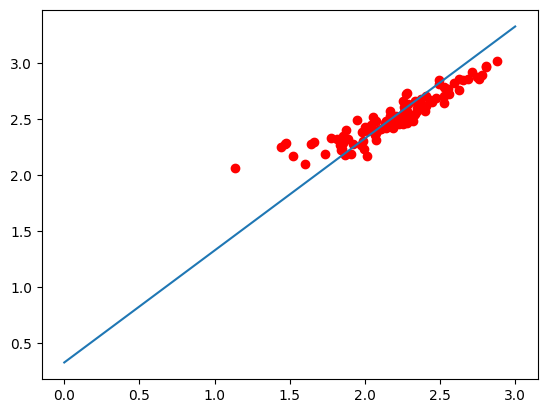

0.3298912261094465


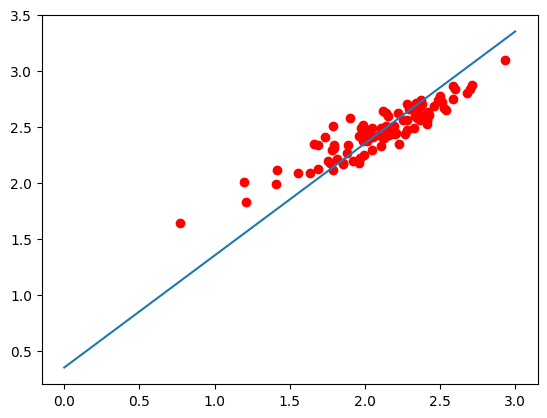

0.35115955851078795


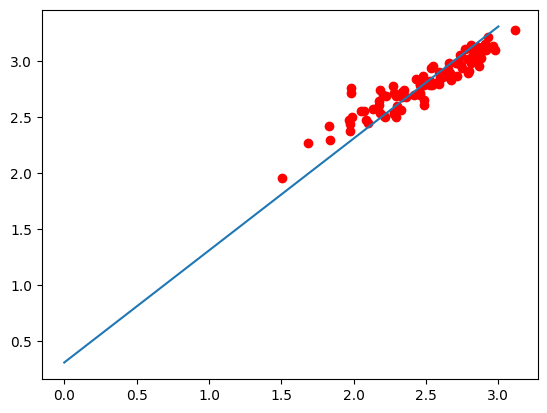

0.3126730504370526


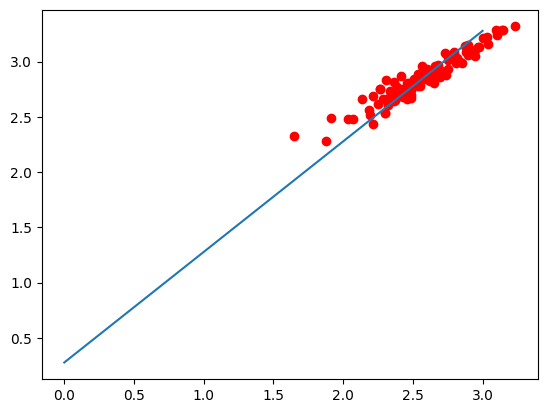

0.2775162954313236


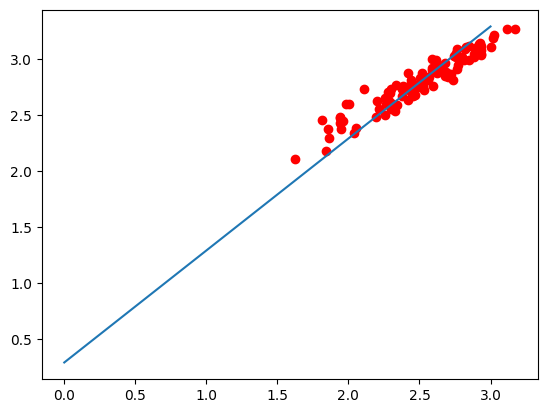

0.2913128698988844


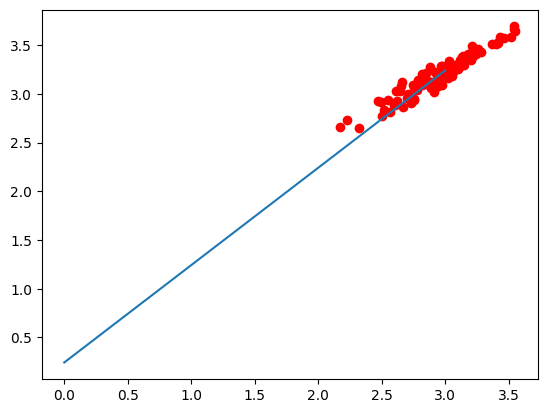

0.2422030878011186


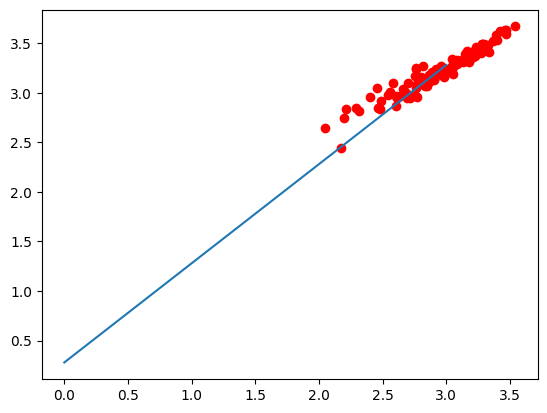

0.27936060031131205


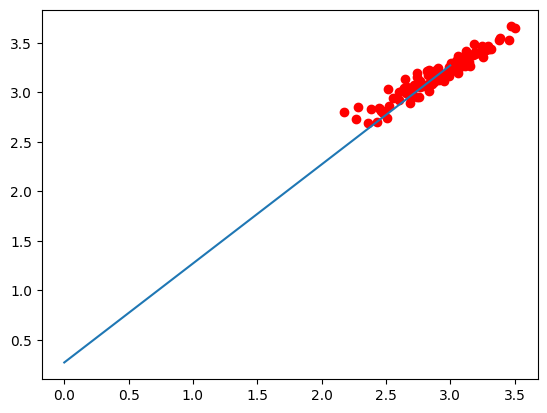

0.2717809564107029


In [41]:
for i in range(7,10):
    for j in range(3):
        d,da=experiment_pipeline(2**i)

In [10]:
def compute_geometric_mean(vectors,smooth=False):
    num_vectors=len(vectors)
    mean=np.zeros(len(vectors[0]))
    t_vectors=[]
    for i in range(num_vectors):
        x=vectors[i]
        t=transform_vector(x,smooth)
        t_vectors.append(t)
        mean+=t
    mean/=num_vectors
    return mean,t_vectors

In [11]:
vectors=[]
core=MIGCore()
r1=generate_real_Toeplitz_covariance(128)
R1=core.build_toeplitz_matrix(r1)

for i in range(10):
    x=generate_samples(R1,1)
    x=x.ravel()
    vectors.append(x)
vectors

[array([ 0.51492169-2.26981409j, -0.62955685-0.18613476j,
        -0.32505005-0.48275465j,  0.09216615+0.25021081j,
         0.12313846+0.39147628j,  0.12208208+0.05937953j,
         0.10159064-0.15826225j, -0.41638908+0.31445699j,
         0.12161651-0.84835223j, -1.70083526+0.91742403j,
         0.38296777+1.22689181j, -0.73308823+1.19831116j,
         0.99167099+0.45504937j, -1.30370584+0.51217555j,
        -0.48012692+0.23127891j,  0.03474737-0.392705j  ,
        -0.67017678-0.29303139j, -0.12229842-0.0496039j ,
        -0.63840038+0.43302385j,  0.1109864 -0.24060791j,
         0.30778499-0.08770752j,  0.11429433+0.22367797j,
        -0.60981726-0.48771277j,  0.5774449 -0.2841787j ,
        -0.23451352-0.11742094j, -0.30661875-0.81070564j,
        -0.3823233 +0.26570383j, -0.02954013-0.16109064j,
        -0.42076169-0.69547056j, -0.20804764+0.65971807j,
        -0.56143689-0.33173919j,  1.94436518-0.18633392j,
        -0.49024163-0.22986192j, -0.02409085-0.19969065j,
        -0.703

In [73]:
m,t=compute_geometric_mean(vectors,smooth=False)

In [74]:
m.shape

(128,)

In [76]:
d=[np.linalg.norm(m-t[i])for i in range(len(t))]

In [77]:
d

[np.float64(14.474410704939736),
 np.float64(13.101918985335562),
 np.float64(17.298185927180235),
 np.float64(12.32528026497131),
 np.float64(12.477202376604417),
 np.float64(12.955380725144455),
 np.float64(11.855023258995836),
 np.float64(12.570607747426067),
 np.float64(15.111839784553702),
 np.float64(12.165162545307282)]

In [12]:
def compare():
    vectors1=[]
    vectors2=[]
    core=MIGCore()
    r1=generate_real_Toeplitz_covariance(128)
    R1=core.build_toeplitz_matrix(r1)
    r2=generate_real_Toeplitz_covariance(128)
    R2=core.build_toeplitz_matrix(r2)
    for i in range(10):
        x=generate_samples(R1,1)
        x=x.ravel()
        vectors1.append(x)
        y=generate_samples(R2,1)
        y=y.ravel()
        vectors2.append(y)
    m1,t1=compute_geometric_mean(vectors1,smooth=True)
    m2,t2=compute_geometric_mean(vectors2,smooth=True)
    return m1,t1,m2,t2,R1,R2

In [150]:
m1,t1,m2,t2,R1,R2=compare()

In [151]:
d1=[np.linalg.norm(m1-t1[i])for i in range(len(t1))]

In [152]:
d2=[np.linalg.norm(m2-t2[i])for i in range(len(t2))]

In [153]:
d1

[np.float64(3.824409652473875),
 np.float64(3.875271331035171),
 np.float64(3.1928759860785387),
 np.float64(4.110562132534229),
 np.float64(3.7370484702031788),
 np.float64(3.708617213792582),
 np.float64(3.787714916140141),
 np.float64(4.03288206315141),
 np.float64(3.8068033846500957),
 np.float64(4.1788314908055355)]

In [154]:
d2

[np.float64(3.7556209710238324),
 np.float64(3.173408021763945),
 np.float64(4.374115512053744),
 np.float64(3.3821896225023904),
 np.float64(4.169657672816427),
 np.float64(3.4560836577961362),
 np.float64(3.574048658882898),
 np.float64(2.998560189550707),
 np.float64(5.467087502545333),
 np.float64(4.248275687842003)]

In [155]:
c1=[np.linalg.norm(m2-t1[i])for i in range(len(t1))]

In [156]:
c1

[np.float64(8.667243265125544),
 np.float64(7.627920990570021),
 np.float64(7.881879496711464),
 np.float64(8.693092689375646),
 np.float64(8.309668836000352),
 np.float64(8.16470903123771),
 np.float64(8.597768334909142),
 np.float64(8.571256762597898),
 np.float64(8.171377564181828),
 np.float64(8.930302889952415)]

In [157]:
d_real=riemannian_distance(R1,R2)

In [158]:
d_real

np.float64(34.84928837111003)

In [159]:
np.linalg.norm(m1-m2)

np.float64(7.4404524605119695)

In [13]:
def target_matrix(n):
    theta=np.random.random()*2*np.pi
    vec=np.array([np.exp(theta*1j*i) for i in range(n)])
    vec=vec.reshape(-1,1)
    arr=vec@vec.T
    return arr
target_matrix(3)

array([[ 1.        +0.j        , -0.8146723 -0.57992158j,
         0.32738193+0.9448921j ],
       [-0.8146723 -0.57992158j,  0.32738193+0.9448921j ,
         0.28125433-0.95963327j],
       [ 0.32738193+0.9448921j ,  0.28125433-0.95963327j,
        -0.78564215+0.61868119j]])

In [38]:
def model_target(epsilon=1e-1):
    vectors1=[]
    vectors2=[]
    core=MIGCore()
    n=256
    r1=generate_real_Toeplitz_covariance(n)
    R1=core.build_toeplitz_matrix(r1)
    R2=R1+epsilon*target_matrix(n)
    for i in range(10):
        x=generate_samples(R1,1)
        x=x.ravel()
        vectors1.append(x)
        y=generate_samples(R2,1)
        y=y.ravel()
        vectors2.append(y)
    m1,t1=compute_geometric_mean(vectors1,smooth=True)
    m2,t2=compute_geometric_mean(vectors2,smooth=True)
    return m1,t1,m2,t2,R1,R2

In [39]:
m1,t1,m2,t2,R1,R2=model_target(0.005)

In [40]:
d1=[np.linalg.norm(m1-t1[i])for i in range(len(t1))]
d2=[np.linalg.norm(m2-t2[i])for i in range(len(t2))]

In [41]:
d1

[np.float64(4.060507288929464),
 np.float64(4.974479316749286),
 np.float64(4.612873304267382),
 np.float64(4.5559694854692445),
 np.float64(4.329901740927637),
 np.float64(4.359469552467417),
 np.float64(5.514242762860399),
 np.float64(4.37082931022785),
 np.float64(4.900386147452375),
 np.float64(4.575340459191426)]

In [42]:
d2

[np.float64(4.596770532516123),
 np.float64(4.110960077295666),
 np.float64(3.792061794617354),
 np.float64(3.775444781212247),
 np.float64(3.469098376312028),
 np.float64(3.742747174705641),
 np.float64(4.478799200889705),
 np.float64(4.340031934093263),
 np.float64(4.3301684085413115),
 np.float64(4.580066902072488)]

In [43]:
c1=[np.linalg.norm(m2-t1[i])for i in range(len(t1))]
c1

[np.float64(4.624671833095274),
 np.float64(6.128351784511312),
 np.float64(5.130182156738762),
 np.float64(5.194635167886367),
 np.float64(5.162963170648905),
 np.float64(5.763687476785588),
 np.float64(5.521225835231369),
 np.float64(4.878503350746236),
 np.float64(4.909498284460488),
 np.float64(5.005639467854215)]

In [44]:
d_real=riemannian_distance(R1,R2)
d_real

np.float64(1.14907626194322)

In [45]:
np.linalg.norm(m1-m2)

np.float64(2.45125901445492)

In [46]:
R1

array([[ 1.00000000e+00+0.00000000e+00j, -2.51661100e-01+1.24646002e-01j,
        -4.66680285e-02+4.06394518e-01j, ...,
        -2.32830417e-04+1.40001544e-03j,  1.94813207e-03-3.06500329e-03j,
        -2.51411999e-03+9.32319462e-04j],
       [-2.51661100e-01-1.24646002e-01j,  1.00000000e+00+0.00000000e+00j,
        -2.51661100e-01+1.24646002e-01j, ...,
         2.78167790e-04-1.73101279e-04j, -2.32830417e-04+1.40001544e-03j,
         1.94813207e-03-3.06500329e-03j],
       [-4.66680285e-02-4.06394518e-01j, -2.51661100e-01-1.24646002e-01j,
         1.00000000e+00+0.00000000e+00j, ...,
        -1.64099696e-03+2.52548190e-04j,  2.78167790e-04-1.73101279e-04j,
        -2.32830417e-04+1.40001544e-03j],
       ...,
       [-2.32830417e-04-1.40001544e-03j,  2.78167790e-04+1.73101279e-04j,
        -1.64099696e-03-2.52548190e-04j, ...,
         1.00000000e+00+0.00000000e+00j, -2.51661100e-01+1.24646002e-01j,
        -4.66680285e-02+4.06394518e-01j],
       [ 1.94813207e-03+3.06500329e-03j, -2.

In [47]:
np.array(t1+t2)

array([[-0.59005732, -0.4520857 , -0.46204052, ..., -1.0602311 ,
        -0.71603178, -0.66978887],
       [-0.23834417, -0.21003588, -0.17313923, ..., -0.71741479,
        -0.50927702, -0.52012726],
       [-0.14079512,  0.02975373,  0.13110119, ..., -0.67582554,
        -0.40931602, -0.26706738],
       ...,
       [-0.23006915,  0.11720973,  0.31049511, ..., -0.34156224,
        -0.25801636, -0.27086725],
       [ 0.11171375,  0.15225209,  0.21178589, ..., -0.51954759,
        -0.40003844,  0.05595475],
       [-0.65523859, -0.62282496, -0.66546915, ..., -0.91446046,
        -0.72502765, -0.68056868]], shape=(20, 256))

[0.19249251 0.13343046]


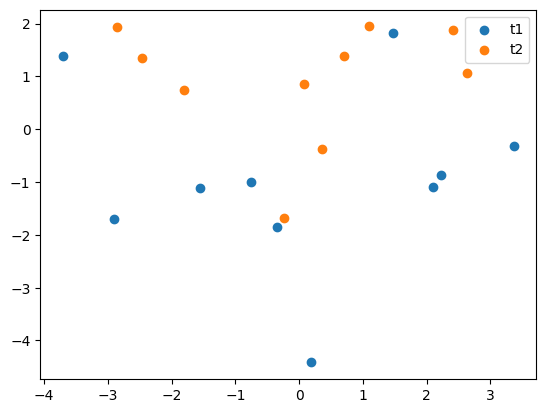

In [49]:
#perform pca on t1 and t2
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
all_points=np.array(t1+t2)
pca_result = pca.fit_transform(all_points)

#show saved information

print(pca.explained_variance_ratio_)
#plot results

import matplotlib.pyplot as plt
plt.scatter(pca_result[:len(t1), 0], pca_result[:len(t1), 1], label='t1')
plt.scatter(pca_result[len(t1):, 0], pca_result[len(t1):, 1], label='t2')
plt.legend()
plt.show()

In [50]:
def circular_moving_average(signals, hw):
        """循环移动平均，hw为半宽"""
        n_sig = signals.shape[1]
        smoothed = np.zeros_like(signals)
        
        for i in range(n_sig):
            # 循环索引：i-hw 到 i+hw
            indices = np.arange(i - hw, i + hw + 1) % n_sig
            smoothed[i] = np.mean(signals[:, indices], axis=1)
        
        return smoothed
def whole_pipeline(rd_data:ndarray):
    #perform dft on doppler axis
    n = rd_data.shape[1]
    dft_data = np.fft.fft(rd_data, axis=1)
    #compute spectral energy
    spectral_energy = np.abs(dft_data) ** 2/n
    #perform moving average for each range bin
    hw=int(np.round(n**0.8 / (4 * np.pi)))
    smoothed_energy = circular_moving_average(spectral_energy, hw=hw)
    epsilon=1e-10
    Lx = np.log(np.maximum(smoothed_energy, epsilon))
    return Lx